#Classsifiction with Pointet using Kaolin


To choose the GPU for training, select Runtime > Change runtime type choose hardware accelerator (change None to GPU).

#Installing dependencies

In [1]:
# KAOLIN
!git clone https://github.com/NVIDIAGameWorks/kaolin.git
%cd kaolin
!git checkout v0.1
!python setup.py develop

#NUSCENES
!pip install nuscenes-devkit

#PIXIEDUST
!pip install pixiedust

Cloning into 'kaolin'...
remote: Enumerating objects: 1845, done.
remote: Total 1845 (delta 0), reused 0 (delta 0), pack-reused 1845
Receiving objects: 100% (1845/1845), 53.63 MiB | 13.86 MiB/s, done.
Resolving deltas: 100% (922/922), done.
/content/kaolin
Note: checking out 'v0.1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at c537bf7 update readme (#317)
WARNING - Kaolin is tested with PyTorch >=1.2.0, <1.5.0 Found version 1.7.0+cu101 instead.
WARNING - Kaolin is tested with torchvision >=0.4.0, <0.6.0 Found version 0.8.1+cu101 instead.
Building nv-usd...
Adjusting /root/.profile
Adjusting /root/.bashrc
Creating packm

#Collect the necessary data

In [2]:
!pip install gdown

!gdown https://drive.google.com/uc?id=1p5U25YZdCi-8FjdoffiJyhhqh1uuqpCi
!gdown https://drive.google.com/uc?id=16fkgESWRPDzgmIXOH2FfKK2xymbj11of

!unzip datasets_own.zip -d /content/kaolin/kaolin
!unzip picozense_DCAM710_data.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/vertical_plane_59.vtk  
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/vertical_plane_83.vtk  
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/vertical_plane_134.vtk  
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/vertical_plane_17.vtk  
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/vertical_plane_13.vtk  
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/vertical_plane_5.vtk  
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/vertical_plane_75.vtk  
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/vertical_plane_135.vtk  
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/vertical_plane_26.vtk  
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/vertical_plane_173.vtk  
  inflating: /content/picozense_DCAM710_data/vertical_plane/vtk/ver

#Metaclass = KaolinDatasetMeta error handling

Changing line 56 in kaolin/datasets/base.py from

class KaolinDataset(Dataset, metaclass=KaolinDatasetMeta):
to
class KaolinDataset(Dataset)

In [3]:
import fileinput

with fileinput.FileInput("/content/kaolin/kaolin/datasets/base.py", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("class KaolinDataset(Dataset, metaclass=KaolinDatasetMeta)", "class KaolinDataset(Dataset)"), end='')

**RESTART runtime in order to have the Kaolin available for import!**

#Import dependencies

In [1]:
import time
import torch
import itertools
import pixiedust
import numpy as np
import kaolin as kal
import kaolin.transforms as tfs
import matplotlib.pyplot as plt

from tqdm import tqdm
from kaolin.visualize import vis
from kaolin.datasets import ModelNet
from kaolin import ClassificationEngine
from torch.utils.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.debugger import set_trace
from sklearn.metrics import confusion_matrix
from kaolin.datasets_own import ModelNet as ModelNet2
from kaolin.models.PointNet import PointNetClassifier

print("Torch version = ", torch.__version__)
print("Kaolin version = ", kal.__version__)


Pixiedust database opened successfully


Torch version =  1.7.0+cu101
Kaolin version =  0.1.0


#Define Visualize Batch function

In [2]:
def visualize_batch(pointclouds, pred_labels, labels, categories):
    batch_size = len(pointclouds)
    fig = plt.figure(figsize=(8, batch_size / 2))

    ncols = 5
    nrows = max(1, batch_size // 5)
    for idx, pc in enumerate(pointclouds):
        label = categories[labels[idx].item()]
        pred = categories[pred_labels[idx]]
        colour = 'g' if label == pred else 'r'
        pc = pc.cpu().numpy()
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colour, s=2)
        ax.axis('off')
        ax.set_title('GT: {0}\nPred: {1}'.format(label, pred))
    plt.show()


#Local variables declaration

In [3]:
modelnet_path = '/content/picozense_DCAM710_data'
model_path = '/content/'
model_name = 'modelnet'

learning_rate = 1e-3
num_points = 1024
epochs_nr = 10

**TODO:** Defines objects for recognition

Hint: *The folder names from "/content/kaolin/picozense_DCAM710_data", means the categories witch can be used for training and validation.*

In [4]:
categories = ['cylinder', 'sphere', 'vertical_plane', 'horizontal_plane']

This command defines a transform that first converts a mesh representation to a pointcloud and then normalizes it to be centered at the origin, and have a standard deviation of 1. Much like images, 3D data such as pointclouds need to be normalized for better classification performance.

In [5]:
transform = tfs.Compose([tfs.TriangleMeshToPointCloud(num_samples=num_points), tfs.NormalizePointCloud()])

In [6]:
model_net_train = ModelNet(modelnet_path, categories=categories, split='train', transform=transform)

In [7]:
model_net_val = ModelNet(modelnet_path, categories=categories, split='test', transform=transform)

**TODO:** Declare training loader

Hint: *To get more information, please check the following [link](https://pytorch.org/docs/stable/data.html).*

In [8]:
train_loader = DataLoader(model_net_train, batch_size=15, shuffle=True, num_workers=0, pin_memory=False)

**TODO**: Declare validation loader

Hint: *To get more information, please check the following [link](https://pytorch.org/docs/stable/data.html).*

In [9]:
val_loader = DataLoader(model_net_val, batch_size=15, num_workers=0, pin_memory=False)

In [10]:
val_batch, labels = next(iter(val_loader))

#Training

In [11]:
model = PointNetClassifier(num_classes=len(categories)).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
start_time = time.time()

catlen=len(categories)

cmt = torch.zeros(catlen,catlen, dtype=torch.int64)
cmt_all = cmt
cm=cmt
cm_all = cmt

all_preds = torch.tensor([])
all_preds = all_preds.cuda()
all_real = torch.tensor([])
all_real = all_real.cuda()

for e in range(epochs_nr):

    print('###################')
    print('Epoch:', e)
    print('###################')

    train_loss = 0.
    train_accuracy = 0.
    num_batches = 0

    model.train()
    
    for idx, (data, attributes) in enumerate(tqdm(train_loader)):
        category = attributes['category'].cuda()
        pred = model(data.cuda())
        loss = criterion(pred, category.view(-1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Compute accuracy
        pred_label = torch.argmax(pred, dim=1)
        train_accuracy += torch.mean((pred_label == category.view(-1)).float()).detach().cpu().item()
        num_batches += 1

    print('Train loss:', train_loss / num_batches)
    print('Train accuracy:', train_accuracy / num_batches)

    val_loss = 0.
    val_accuracy = 0.
    num_batches = 0

    model.eval()

    epoch_preds = torch.tensor([])
    epoch_preds = epoch_preds.cuda()
    epoch_real = torch.tensor([])
    epoch_real = epoch_real.cuda()
    
    cmt = torch.zeros(catlen,catlen, dtype=torch.int64)
    cm=cmt
    
    with torch.no_grad():
        for idx, (data, attributes) in enumerate(tqdm(val_loader)):
            category = attributes['category'].cuda()
            pred = model(data.cuda())
            loss = criterion(pred, category.view(-1))
            val_loss += loss.item()

            # Compute accuracy
            pred_label = torch.argmax(pred, dim=1)
            val_accuracy += torch.mean((pred_label == category.view(-1)).float()).cpu().item()
            num_batches += 1
               
            epoch_preds = torch.cat((epoch_preds, pred_label.float()),dim=0)
            epoch_real = torch.cat((epoch_real, category.view(-1).float()),dim=0)
            all_preds = torch.cat((all_preds, pred_label.float()),dim=0)
            all_real = torch.cat((all_real, category.view(-1).float()),dim=0)
    
    stacked = torch.stack((epoch_real,epoch_preds),dim=1)
    cm = confusion_matrix(epoch_real.cpu(), epoch_preds.cpu())

    for p in stacked:
        tl, pl = p.tolist()
        tl=int(tl)
        pl=int(pl)
        cmt[tl, pl] = cmt[tl, pl] + 1
        cmt_all[tl, pl] = cmt_all[tl, pl] + 1
                
    print('Val loss:', val_loss / num_batches)
    print('Val accuracy:', val_accuracy / num_batches)

end_time = time.time()
print('Training time: {}'.format(end_time - start_time))
print('conf. matrix cmt:')

cm_all = confusion_matrix(all_real.cpu(), all_preds.cpu())
print(cm_all)

  0%|          | 0/69 [00:00<?, ?it/s]

###################
Epoch: 0
###################


  9%|▊         | 3/35 [00:00<00:01, 28.05it/s]

Train loss: 0.37665593678104703
Train accuracy: 0.8714976364719695


  1%|▏         | 1/69 [00:00<00:09,  7.31it/s]

Val loss: 0.27814096024792107
Val accuracy: 0.8628571663584028
###################
Epoch: 1
###################


 11%|█▏        | 4/35 [00:00<00:00, 34.53it/s]

Train loss: 0.19979058940341507
Train accuracy: 0.9256039080412491


  1%|▏         | 1/69 [00:00<00:07,  9.19it/s]

Val loss: 0.29976936975519625
Val accuracy: 0.8895238263266427
###################
Epoch: 2
###################


 11%|█▏        | 4/35 [00:00<00:00, 33.84it/s]

Train loss: 0.1977410220230619
Train accuracy: 0.9246377253877944


  1%|▏         | 1/69 [00:00<00:08,  7.98it/s]

Val loss: 0.28330567787800515
Val accuracy: 0.918095258304051
###################
Epoch: 3
###################


 11%|█▏        | 4/35 [00:00<00:01, 30.27it/s]

Train loss: 0.1888039075513033
Train accuracy: 0.9294686351997264


  1%|▏         | 1/69 [00:00<00:06,  9.87it/s]

Val loss: 0.18886241961403616
Val accuracy: 0.9180952659675053
###################
Epoch: 4
###################


 11%|█▏        | 4/35 [00:00<00:00, 34.42it/s]

Train loss: 0.15513611252865064
Train accuracy: 0.9449275732040405


  0%|          | 0/69 [00:00<?, ?it/s]

Val loss: 0.4969886653054874
Val accuracy: 0.8495238253048488
###################
Epoch: 5
###################


 11%|█▏        | 4/35 [00:00<00:00, 34.89it/s]

Train loss: 0.13693116385948614
Train accuracy: 0.9449275688848634


  0%|          | 0/69 [00:00<?, ?it/s]

Val loss: 0.09883406807847288
Val accuracy: 0.9638095327786037
###################
Epoch: 6
###################


 11%|█▏        | 4/35 [00:00<00:00, 35.24it/s]

Train loss: 0.11249050891458773
Train accuracy: 0.9507246734439463


  0%|          | 0/69 [00:00<?, ?it/s]

Val loss: 0.13574118105129207
Val accuracy: 0.942857163293021
###################
Epoch: 7
###################


 11%|█▏        | 4/35 [00:00<00:00, 35.33it/s]

Train loss: 0.08436505593008538
Train accuracy: 0.965217417564945


  0%|          | 0/69 [00:00<?, ?it/s]

Val loss: 0.06233184055641427
Val accuracy: 0.9771428687231881
###################
Epoch: 8
###################


 11%|█▏        | 4/35 [00:00<00:00, 33.02it/s]

Train loss: 0.11782051212545755
Train accuracy: 0.9468599385109501


  1%|▏         | 1/69 [00:00<00:07,  8.68it/s]

Val loss: 0.13218405739088276
Val accuracy: 0.9504762053489685
###################
Epoch: 9
###################


 11%|█▏        | 4/35 [00:00<00:00, 34.54it/s]

Train loss: 0.11857360279511499
Train accuracy: 0.9545894066492716


100%|██████████| 35/35 [00:04<00:00,  7.68it/s]


Val loss: 0.09696935345917675
Val accuracy: 0.9600000160081046
Training time: 139.15154194831848
conf. matrix cmt:
[[ 795   88   32   45]
 [ 122  380   12    6]
 [  24    4  563   39]
 [   9    0   22 3069]]


#Saving model

In [12]:
torch.save(model, model_path + model_name+ ".pt") 

#Evaluate confusion matrix

Normalized confusion matrix
[[0.828125   0.09166667 0.03333333 0.046875  ]
 [0.23461538 0.73076923 0.02307692 0.01153846]
 [0.03809524 0.00634921 0.89365079 0.06190476]
 [0.00290323 0.         0.00709677 0.99      ]]


Text(0.5, -21.608192780205968, 'Predicted label')

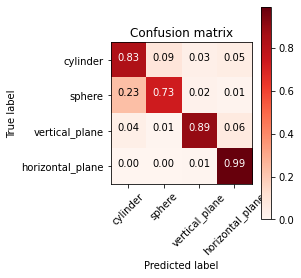

In [13]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(catlen,catlen))
cmf=cm_all
classes=categories
normalize=True
title='Confusion matrix'
cmap=plt.cm.Reds

if normalize:
    cmf = cmf.astype('float') / cmf.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

print(cmf)
plt.imshow(cmf, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f' if normalize else 'd'
thresh = cmf.max() / 2.
for i, j in itertools.product(range(cmf.shape[0]), range(cmf.shape[1])):
    plt.text(j, i, format(cmf[i, j], fmt), horizontalalignment="center", color="white" if cmf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Evaluate the results

In [14]:
import matplotlib.image as mpimg
from IPython.display import Image
from IPython.display import display, clear_output

model = torch.load(model_path + model_name + ".pt")
model.eval()

data, attr = next(iter(val_loader))
data = data.to('cuda')

labels = attr['category'].to('cuda')
preds = model(data)
pred_labels = torch.max(preds, axis=1)[1]
 
get_ipython().run_line_magic('matplotlib', 'notebook')

**TODO:** Plot the results by using the *visualize_batch* function.

Hint: to check how the function is working and about the input parameters, please check the **Define Visualize Batch function** section.

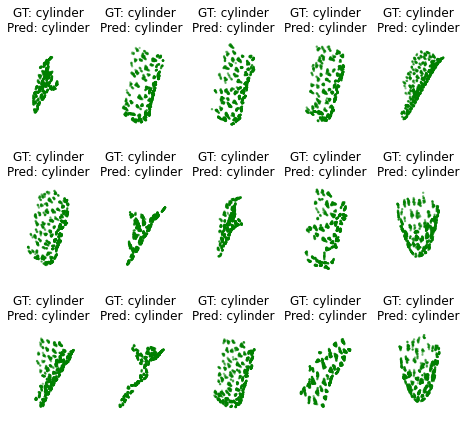

In [15]:
%matplotlib inline
visualize_batch(data, pred_labels, labels, categories)